In [1]:
# import packages
import numpy as np
import scipy
import seaborn as sns
from matplotlib import pyplot as plt
import time
import pandas as pd

sns.set_theme()

### Question 3
<b>a) n = 1000, p = 5000</b>

In [2]:
# define n and p
n = 1000
p = 5000

# generate matrix X
X = np.random.standard_normal(size=(n, p))

# standardize each column of X
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# generate a random sparse vector Beta with 0.05 nonzero entries
Beta_true = scipy.sparse.random(p, 1, density=0.05)

# define Y
y = X * Beta_true + 0.01 * np.random.normal(0, 1, size = (X * Beta_true).shape)

<b>b)</b>

In [3]:
# define tuning parameter lambda
lamb = 0.1 * np.abs(np.matmul(X.T, y)).max()

# define L
L = np.linalg.eig(np.matmul(X.T, X))[0].max().real

# define step size alpha
alpha = 1 / L

print('Lambda: ', lamb)
print('L: ', L)
print('Alpha: ', alpha)

Lambda:  178.2336524894858
L:  10516.43125347582
Alpha:  9.508929178512785e-05


In [4]:
def cd_lasso_iter_base(X, y, num_iter, tol, lamb):
    beta = np.zeros((X.shape[1],1))  # initialize beta
    norm_grad1 = []
    tk = []
    start_time = time.time()
    for j in range(num_iter):
        beta_previous = beta
        for i in range(X.shape[1]):
            Xi = X[:, i]
            ni = np.matmul(Xi.T, Xi)
            update = beta[i] - np.matmul(Xi.T, np.matmul(X, beta) - y) / ni
            beta[i] = np.sign(update) * max(abs(update) - lamb / ni, 0)
        term = [np.sign(i) * max(abs(i) - lamb, 0) for i in (beta - np.matmul(X.T, np.matmul(X, beta) - y))]
        norm_grad1.append(np.linalg.norm(np.array(beta) - np.array(term), 2))
        tk.append(time.time() - start_time)
        if norm_grad1[-1] < tol:
            break
    return norm_grad1, tk


def pg_lasso_iter_base(X, y, num_iter, tol, lamb, alpha):
    beta = np.zeros((X.shape[1],1))  # initialize beta
    norm_grad2 = []
    tk = []
    start_time = time.time()
    for j in range(num_iter):
        update = beta - alpha * np.matmul(X.T, np.matmul(X, beta) - y)
        beta = [np.sign(i) * max(abs(i) - lamb * alpha, 0) for i in update]
        update = beta - np.matmul(X.T, np.matmul(X, beta) - y)
        term = [np.sign(i) * max(abs(i) - lamb, 0) for i in update]
        norm_grad2.append(np.linalg.norm(np.array(beta) - np.array(term), 2))
        tk.append(time.time() - start_time)
        if norm_grad2[-1] < tol:
            break
    return norm_grad2, tk


def apg_lasso_iter_base(X, y, num_iter, tol, lamb, alpha):
    beta = np.zeros((X.shape[1],1))  # initialize beta
    norm_grad3 = []
    tk = []
    t = np.zeros((num_iter + 1, 1))
    t[0] = 1
    t[1] = 1
    for i in range(2, num_iter + 1):
        t[i] = (1 + np.sqrt(1 + 4 * t[i-1] ** 2)) / 2
    beta_previous = beta
    start_time = time.time()
    for j in range(num_iter):
        beta_bar = beta + (t[j] - 1) / t[j + 1] * (np.array(beta) - np.array(beta_previous))
        update = beta_bar - alpha * np.matmul(X.T, np.matmul(X, beta_bar) - y)
        beta_new = [np.sign(i) * max(abs(i) - lamb * alpha, 0) for i in update]
        update = beta_new - np.matmul(X.T, np.matmul(X, beta_new) - y)
        term = [np.sign(i) * max(abs(i) - lamb, 0) for i in update]
        norm_grad3.append(np.linalg.norm(np.array(beta_new) - np.array(term), 2))
        beta_previous = beta
        beta = beta_new
        tk.append(time.time() - start_time)
        if norm_grad3[-1] < tol:
            break
    return norm_grad3, tk


def apg_restart_lasso_iter_base(X, y, num_iter, tol, lamb, alpha):
    beta = np.zeros((X.shape[1],1))  # initialize beta
    norm_grad4 = []
    t = np.zeros((100 + 1, 1))
    t[0] = 1
    t[1] = 1
    for i in range(2, 100 + 1):
        t[i] = (1 + np.sqrt(1 + 4 * t[i-1] ** 2)) / 2
    beta_previous = beta
    tk =[]
    start_time = time.time()
    for i in range(int(num_iter / 100)):
        for j in range(100):
            beta_bar = beta + (t[j] - 1) / t[j + 1] * (np.array(beta) - np.array(beta_previous))
            update = beta_bar - alpha * np.matmul(X.T, np.matmul(X, beta_bar) - y)
            beta_new = [np.sign(i) * max(abs(i) - lamb * alpha, 0) for i in update]
            update = beta_new - np.matmul(X.T, np.matmul(X, beta_new) - y)
            term = [np.sign(i) * max(abs(i) - lamb, 0) for i in update]
            norm_grad4.append(np.linalg.norm(np.array(beta_new) - np.array(term), 2))
            beta_previous = beta
            beta = beta_new
            tk.append(time.time() - start_time)
            if norm_grad4[-1] < tol:
                break
    return norm_grad4, tk

In [5]:
norm_grad_cd, tk_cd = cd_lasso_iter_base(X, y, 100, 0.001, lamb)
norm_grad_pg, tk_pg = pg_lasso_iter_base(X, y, 2000, 0.001, lamb, alpha)
norm_grad_apg, tk_apg = apg_lasso_iter_base(X, y, 2000, 0.001, lamb, alpha)
norm_grad_apg_restart, tk_apg_restart = apg_restart_lasso_iter_base(X, y, 2000, 0.001, lamb, alpha)

<b>c) plot a figure of the relative residual error in
base-10 logarithmic scale</b>

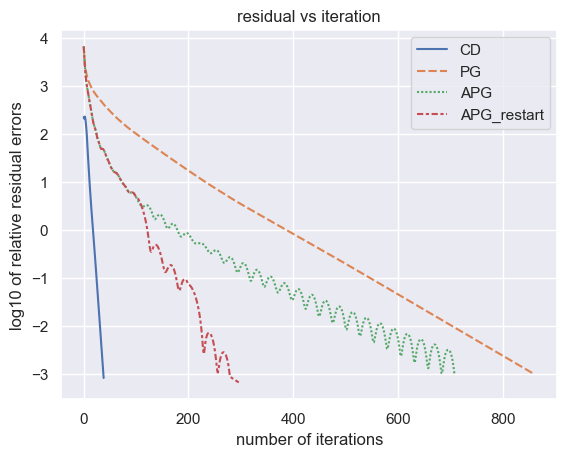

In [6]:
df_residual = pd.DataFrame({'iteration': pd.Series(np.arange(1,2001)),
                            'CD': pd.Series(np.log10(norm_grad_cd).flatten()),
                            'PG': pd.Series(np.log10(norm_grad_pg).flatten()),
                            'APG': pd.Series(np.log10(norm_grad_apg).flatten()),
                            'APG_restart': pd.Series(np.log10(norm_grad_apg_restart).flatten())})

fig1 = sns.lineplot(data=df_residual[['CD', 'PG', 'APG', 'APG_restart']]);
fig1.set(xlabel='number of iterations', 
         ylabel='log10 of relative residual errors',
         title='residual vs iteration');

<b>d) plot a figure of the relative residual errors over running time</b>

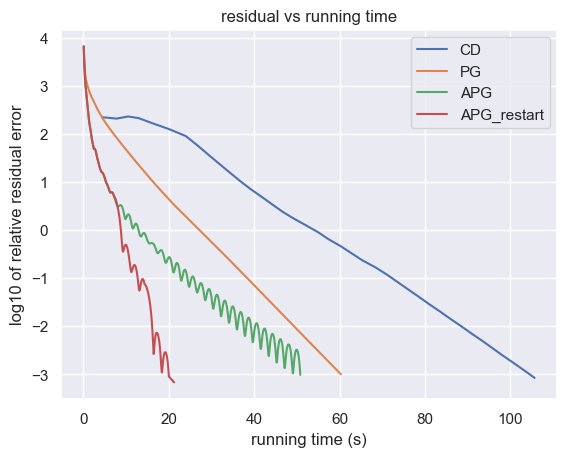

In [7]:
df_cd = pd.DataFrame({'running_time': tk_cd,
                      'CD': np.log10(norm_grad_cd).flatten()})
df_pg = pd.DataFrame({'running_time': tk_pg,
                      'PG': np.log10(norm_grad_pg).flatten()})
df_apg = pd.DataFrame({'running_time': tk_apg,
                      'APG': np.log10(norm_grad_apg).flatten()})
df_apg_restart = pd.DataFrame({'running_time': tk_apg_restart,
                               'APG_restart': np.log10(norm_grad_apg_restart).flatten()})

line1 = sns.lineplot(data=df_cd, x="running_time", y="CD", label = 'CD')
line2 = sns.lineplot(data=df_pg, x="running_time", y="PG", label = 'PG')
line3 = sns.lineplot(data=df_apg, x="running_time", y="APG", label = 'APG')
line4 = sns.lineplot(data=df_apg_restart, x="running_time", y="APG_restart", label = 'APG_restart')
plt.xlabel("running time (s)")
plt.ylabel("log10 of relative residual error")
plt.title("residual vs running time")
plt.show()

<b>e) Test APG and APG restart models with tolerence 10e-10, and record number of iterations and running time</b>

In [8]:
tolerence = 10 ** (-10)
norm_grad_apg2, tk_apg2 = apg_lasso_iter_base(X, y, 3000, tolerence, lamb, alpha)
norm_grad_apg_restart2, tk_apg_restart2 = apg_restart_lasso_iter_base(X, y, 3000, tolerence, lamb, alpha)

In [9]:
df_tol_test = pd.DataFrame({'Relative Residual Error': [norm_grad_apg2[-1], norm_grad_apg_restart2[-1]],
                            'Iterations': [len(norm_grad_apg2), len(norm_grad_apg_restart2)],
                            'Time (sec)': [tk_apg2[-1], tk_apg_restart2[-1]],
                            'Methods': ['APG', 'APG-restart']})
df_tol_test.set_index('Methods')

,Relative Residual Error,Iterations,Time (sec)
Methods,,,
APG,9.320294e-11,2536,183.266056
APG-restart,3.952420e-11,653,46.864885


<b>f) reset tolerance to 10e-6 and alpha, and record number of iterations and running time</b>

In [10]:
tolerence = 10 ** (-6)
alpha2 = 1.5 / L
norm_grad_apg3, tk_apg3 = apg_lasso_iter_base(X, y, 2000, tolerence, lamb, alpha)
norm_grad_apg4, tk_apg4 = apg_lasso_iter_base(X, y, 2000, tolerence, lamb, alpha2)
norm_grad_apg_restart3, tk_apg_restart3 = apg_restart_lasso_iter_base(X, y, 2000, tolerence, lamb, alpha)
norm_grad_apg_restart4, tk_apg_restart4 = apg_restart_lasso_iter_base(X, y, 2000, tolerence, lamb, alpha2)

In [11]:
df_alpha_test = pd.DataFrame({'Relative Residual Error': [norm_grad_apg3[-1], norm_grad_apg4[-1], 
                                                        norm_grad_apg_restart3[-1], norm_grad_apg_restart4[-1]],
                            'Iterations': [len(norm_grad_apg3), len(norm_grad_apg4), 
                                           len(norm_grad_apg_restart3), len(norm_grad_apg_restart4)],
                            'Time (sec)': [tk_apg3[-1], tk_apg4[-1], tk_apg_restart3[-1], tk_apg_restart4[-1]],
                            'Methods': ['APG(alpha = 1/L)', 'APG(alpha = 1.5/L)', 
                                        'APG-restart(alpha = 1/L)', 'APG-restart(alpha = 1.5/L)']})
df_alpha_test.set_index('Methods')

,Relative Residual Error,Iterations,Time (sec)
Methods,,,
APG(alpha = 1/L),9.156187e-07,1389,99.189636
APG(alpha = 1.5/L),9.380027e-07,983,70.049337
APG-restart(alpha = 1/L),5.343602e-07,444,31.644780
APG-restart(alpha = 1.5/L),4.218561e-07,383,27.305433
